In [ ]:
#load libraries
import os
import glob
from eumap import parallel
from eumap.parallel import TilingProcessing
from eumap.raster import read_rasters, save_rasters
from eumap.misc import ttprint
from eumap.misc import find_files
import re
import pandas as pd
import numpy as np
import rasterio
from pathlib import Path
from osgeo import gdal
import geopandas as gpd
import matplotlib.pyplot as plt
import random
from shapely.geometry import Polygon, Point
import matplotlib.pyplot as plt
import matplotlib
from eumap.mapper import LandMapper
from scipy.stats import uniform, randint
import joblib
from eumap.misc import ttprint

In [ ]:
target_col = 'fapar_value'

In [ ]:
#EML model
fn_landmapper = '../models/pot_fapar_eml_sigmoid_v20230921_all3Mio.lz4'
landmapper = LandMapper.load_instance(fn_landmapper)

In [738]:
#load ts test points to predict on
#save to file
ts_path = '../overlay/melted_overlaid_ts_pred_pts_v2023928_corrgeomt.lz4'
ts_pts = joblib.load(ts_path)

In [ ]:
#test prediction p95 actual fapar
ts_pred_actual = landmapper.predict_points(ts_pts)

In [741]:
ts_pts_nohp = ts_pts.copy()
ts_pts_nohp["hfp"] = 0
ts_pts_nohp["nightlights"] = 0
ts_pts_nohp["pop_count"] = 0
ts_pts_nohp["crop_intensity"] = 0
ts_pts_nohp["cropland_ind"] = 0
ts_pts_nohp["shrubland_ind"] = 0
ts_pts_nohp["grassland_ind"] = 0
ts_pts_nohp["forest_ind"] = 100
ts_pts_nohp[ts_pts_nohp.id==1]["forest_ind"] = 0

In [744]:
#test prediction p95 actual fapar
ts_pred_potential = landmapper.predict_points(ts_pts_nohp)

[06:34:10] Predicting 2358 points
[06:34:10] Executing ExtraTreesRegressor
[06:34:12] ExtraTreesRegressor prediction time: 1.50 segs
[06:34:12] Executing XGBRegressor
[06:34:12] XGBRegressor prediction time: 0.14 segs
[06:34:12] Executing Pipeline
[06:34:12] batch_size=1179
2/2 - 1s
[06:34:13] Pipeline prediction time: 1.35 segs
[06:34:13] Executing LinearRegression
[06:34:13] LinearRegression prediction time: 0.02 segs


In [746]:
#merge in 1 dataframe everything with actual, actual by model and potential predicted, and year month ofc, and id
df_ts_pred = ts_pts.copy()
df_ts_pred["pot_fapar_val"] = list(ts_pred_potential[0])
df_ts_pred["pot_fapar_dev"] = list(ts_pred_potential[1])
df_ts_pred["act_fapar_pred"] = list(ts_pred_actual[0])
df_ts_pred["act_fapar_dev"] = list(ts_pred_actual[1])
df_ts_pred

,hfp,pop_count,bio10,bio11,bio12,bio13,bio14,bio15,bio16,bio17,...,id,stratum,diff_tasactual_longterm,diff_practual_longterm,fapar_q,fapar_value,pot_fapar_val,pot_fapar_dev,act_fapar_pred,act_fapar_dev
0,9.0,0.0,3017.0,2989.0,6654.0,1211.0,33.0,645.0,3050.0,458.0,...,1,NaN,0.5,91.0,50,31.0,0.387181,0.032933,0.271246,0.010480
1,11.0,0.0,2999.0,2980.0,20188.0,3426.0,571.0,589.0,9306.0,1847.0,...,2,NaN,0.600006,-828.0,50,214.0,0.893474,0.000791,0.803523,0.033733
2,6.0,0.0,3001.0,2976.0,29289.0,4340.0,312.0,529.0,11998.0,1943.0,...,3,NaN,-0.800018,-1667.0,50,151.0,0.839748,0.022290,0.688081,0.136929
3,9.0,0.0,3017.0,2989.0,6654.0,1211.0,33.0,645.0,3050.0,458.0,...,1,NaN,-0.099976,483.0,50,42.0,0.485732,0.062782,0.375225,0.046687
4,11.0,0.0,2999.0,2980.0,20188.0,3426.0,571.0,589.0,9306.0,1847.0,...,2,NaN,0.5,-201.0,50,219.0,0.894729,0.000573,0.809484,0.030896
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2353,10.0,0.0,2999.0,2980.0,20188.0,3426.0,571.0,589.0,9306.0,1847.0,...,2,NaN,-0.100006,-15062.0,95,153.0,0.903561,0.005225,0.822832,0.031056
2354,6.0,0.0,3001.0,2976.0,29289.0,4340.0,312.0,529.0,11998.0,1943.0,...,3,NaN,-0.399994,-9524.0,95,220.0,0.853704,0.022684,0.794933,0.011554
2355,9.0,0.0,3017.0,2989.0,6654.0,1211.0,33.0,645.0,3050.0,458.0,...,1,NaN,-0.599976,-446.0,95,23.0,0.563806,0.086390,0.444462,0.041953
2356,10.0,0.0,2999.0,2980.0,20188.0,3426.0,571.0,589.0,9306.0,1847.0,...,2,NaN,-0.5,-20769.0,95,153.0,0.902698,0.005062,0.828037,0.029083


In [748]:
#make time series graphs of these
df_ts_pred["yyyymm"] = df_ts_pred.year + df_ts_pred.month
df_ts_pred["actual_fapar"] = df_ts_pred.fapar_value * 0.004
df_ts_pred['yearmonth_dt'] = pd.to_datetime(df_ts_pred['yyyymm'], format='%Y%m', errors='coerce').dropna()
df_ts_pred["potfap_eml_dev_up"] = df_ts_pred.pot_fapar_val + df_ts_pred.pot_fapar_dev
df_ts_pred["potfap_eml_dev_low"] = df_ts_pred.pot_fapar_val - df_ts_pred.pot_fapar_dev
df_ts_pred["actfap_eml_dev_up"] = df_ts_pred.act_fapar_pred + df_ts_pred.act_fapar_dev
df_ts_pred["actfap_eml_dev_low"] = df_ts_pred.act_fapar_pred - df_ts_pred.act_fapar_dev
df_ts_pred_p95 = df_ts_pred[df_ts_pred.fapar_q=='95']
df_ts_pred_p95_somalia = df_ts_pred_p95[df_ts_pred_p95.id==1]
df_ts_pred_p95_brazil = df_ts_pred_p95[df_ts_pred_p95.id==2]
df_ts_pred_p95_colombia = df_ts_pred_p95[df_ts_pred_p95.id==3]

In [750]:
import pandas as pd
import numpy as np
from datetime import timedelta
import matplotlib.dates as mdates
import seaborn as sns

sns.set_theme()
sns.set_style("white")
sns.set_context("talk")

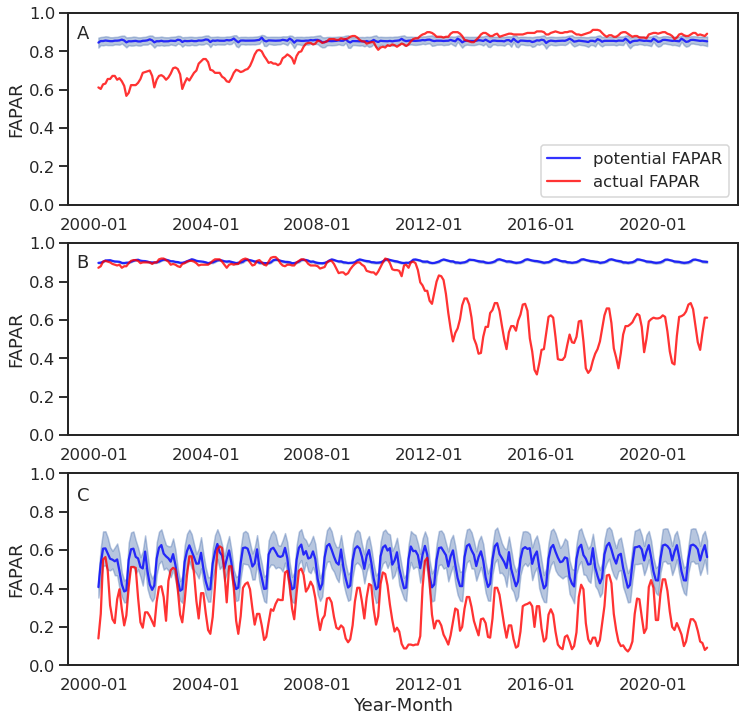

In [758]:
#plot time series
fig = plt.figure(figsize=(12,12))

ax1 = fig.add_subplot(312)
# fig,ax = plt.subplots(figsize=(12, 5))

# ax1 = plt.subplot()
l1, = ax1.plot(df_ts_pred_p95_brazil["yearmonth_dt"], df_ts_pred_p95_brazil["pot_fapar_val"], color = 'blue', alpha=0.8)
# ax1.fill_between(trees_grid, test_acc.mean(axis=1) - test_acc.std(axis=1), test_acc.mean(axis=1) + test_acc.std(axis=1), color='#888888', alpha=0.4)
plt.fill_between(df_ts_pred_p95_brazil["yearmonth_dt"], df_ts_pred_p95_brazil["potfap_eml_dev_low"], df_ts_pred_p95_brazil["potfap_eml_dev_up"], color='C0', alpha=0.4)
ax1.set_ylabel("FAPAR")
# ax1.set_xlabel("Year-Month")
ax1.set_xticklabels([])
ax1.set_ylim(0,1)

ax2 = ax1.twinx()
l2, = ax2.plot(df_ts_pred_p95_brazil["yearmonth_dt"], df_ts_pred_p95_brazil["actual_fapar"], color = 'red', alpha=0.8)
ax2.set_yticklabels([])
ax2.set_yticks([])
ax2.set_ylim(0,1)

# ax7 = ax1.twinx()
# l7, = ax7.plot(df_ts_pred_p95_brazil["yearmonth_dt"], df_ts_pred_p95_brazil["act_fapar_pred"], color = 'orange', alpha=0.8)
# ax7.set_yticklabels([])
# ax7.set_yticks([])
# ax7.set_ylim(0,1)

myFmt = mdates.DateFormatter('%Y-%m')
ax1.xaxis.set_major_formatter(myFmt)

# plt.legend([l1, l2], ["potential FAPAR", "actual FAPAR"], loc = "upper right")
fig.text(0.135, 0.85, "A")
# plt.show()


#plot time series
# fig,ax = plt.subplots(figsize=(12, 5))
ax3 = fig.add_subplot(313)
# ax3 = plt.subplot()
l3, = ax3.plot(df_ts_pred_p95_somalia["yearmonth_dt"], df_ts_pred_p95_somalia["pot_fapar_val"], color = 'blue', alpha=0.8)
plt.fill_between(df_ts_pred_p95_somalia["yearmonth_dt"], df_ts_pred_p95_somalia["potfap_eml_dev_low"], df_ts_pred_p95_somalia["potfap_eml_dev_up"], color='C0', alpha=0.4)
ax3.set_ylabel("FAPAR")
ax3.set_xlabel("Year-Month")
ax3.set_ylim(0,1)


ax4 = ax3.twinx()
l4, = ax4.plot(df_ts_pred_p95_somalia["yearmonth_dt"], df_ts_pred_p95_somalia["actual_fapar"], color = 'red', alpha=0.8)
ax4.set_yticklabels([])
ax4.set_yticks([])
ax4.set_ylim(0,1)

# ax8 = ax3.twinx()
# l8, = ax8.plot(df_ts_pred_p95_somalia["yearmonth_dt"], df_ts_pred_p95_somalia["act_fapar_pred"], color = 'orange', alpha=0.8)
# ax8.set_yticklabels([])
# ax8.set_yticks([])
# ax8.set_ylim(0,1)

myFmt = mdates.DateFormatter('%Y-%m')
ax3.xaxis.set_major_formatter(myFmt)

# plt.legend([l1, l2], ["potential FAPAR", "actual FAPAR"], loc = "upper right")
fig.text(0.135, 0.585, "B")
# plt.show()

#plot time series
# fig,ax = plt.subplots(figsize=(12, 5))
ax5 = fig.add_subplot(311)
# ax5 = plt.subplot()
l5, = ax5.plot(df_ts_pred_p95_colombia["yearmonth_dt"], df_ts_pred_p95_colombia["pot_fapar_val"], color = 'blue', alpha=0.8)
plt.fill_between(df_ts_pred_p95_colombia["yearmonth_dt"], df_ts_pred_p95_colombia["potfap_eml_dev_low"], df_ts_pred_p95_colombia["potfap_eml_dev_up"], color='C0', alpha=0.4)

ax5.set_ylabel("FAPAR")
# ax5.set_xlabel("Year-Month")
ax5.set_ylim(0,1)


ax6 = ax5.twinx()
l6, = ax6.plot(df_ts_pred_p95_colombia["yearmonth_dt"], df_ts_pred_p95_colombia["actual_fapar"], color = 'red', alpha=0.8)
ax6.set_yticklabels([])
ax6.set_yticks([])
ax6.set_ylim(0,1)

# ax9 = ax5.twinx()
# l9, = ax9.plot(df_ts_pred_p95_colombia["yearmonth_dt"], df_ts_pred_p95_colombia["act_fapar_pred"], color = 'orange', alpha=0.8)
# ax9.set_yticklabels([])
# ax9.set_yticks([])
# ax9.set_ylim(0,1)

myFmt = mdates.DateFormatter('%Y-%m')
ax5.xaxis.set_major_formatter(myFmt)

plt.legend([l1, l2, l9], ["potential FAPAR", "actual FAPAR"], loc = "lower right")
fig.text(0.135, 0.315, "C")

# fig.savefig('/mnt/freya/julia/potential_fapar/images/figureX_line_plt_pred_pot_fapar_paper_corrgeomt_order.pdf')
plt.show()




In [ ]:
m = landmapper

In [ ]:
covs_rfe = ['hfp',
 'pop_count',
 'bio10',
 'bio11',
 'bio12',
 'bio13',
 'bio14',
 'bio15',
 'bio16',
 'bio17',
 'bio1',
 'bio2',
 'bio3',
 'bio4',
 'bio5',
 'bio6',
 'bio7',
 'gsl',
 'scd',
 'dtm_slope',
 'dtm_aspect-cosine',
 'dtm_aspect-sine',
 'dtm_downlslope.curvature',
 'dtm_upslope.curvature',
 'dtm_elevation',
 'dtm_cti',
 'dtm_neg.openess',
 'dtm_pos.openess',
 'dtm_vbf',
 'siliciclastic.sedimentary',
 'metamorphics',
 'intermediate.volcanics',
 'unconsolidated.sediment',
 'crop_intensity',
 'forest_ind',
 'cropland_ind',
 'grassland_ind',
 'shrubland_ind',
 'geomt_max',
 'geomt_min',
 'geomt_gap_maxmin',
 'accum_pr_monthly',
 'log_csum_pr_annual',
 'tmin_monthly',
 'tmax_monthly',
 'tas_monthly',
 'nightlights',
 'tas_lt_monthly',
 'pr_lt_monthly',
 'diff_tasactual_longterm',
 'diff_practual_longterm',
 'fapar_q']

In [ ]:
#timeless covs to load as vrt
covs_timeless_to_load = ['bio10',
 'bio11',
 'bio12',
 'bio13',
 'bio14',
 'bio15',
 'bio16',
 'bio17',
 'bio1',
 'bio2',
 'bio3',
 'bio4',
 'bio5',
 'bio6',
 'bio7',
 'gsl',
 'scd',
 'dtm_aspect-cosine',
 'dtm_aspect-sine',
 'dtm_downlslope.curvature',
 'dtm_upslope.curvature',
 'dtm_elevation',
 'dtm_cti',
 'dtm_neg.openess',
 'dtm_pos.openess',
 'dtm_vbf', 
 'metamorphics',
 'intermediate.volcanics',
 'unconsolidated.sediment',
 'siliciclastic.sedimentary'
                        ]

fn_static = glob.glob("250m_vrts_timeless/*.vrt")

fn_timeless_layers = [i for i in fn_static if any(i for j in covs_timeless_to_load if str(j) in i)]


fn_forest_100 = '../clm/tmp/pot_forest_biomes_hengl2018_indicator_go_250m_epsg4326_v20230921_tiled.tif'
fn_grassland_100 = '../clm/tmp/pot_grass_biomes_hengl2018_indicator_go_250m_epsg4326_v20230921_tiled.tif'
fn_shrubland_100 = '../clm/tmp/pot_shrub_biomes_hengl2018_indicator_go_250m_epsg4326_v20230921_tiled.tif'


fn_dtm_slope = '../dtm/dtm_slope_merit.dem_m_250m_s0..0cm_2017_v1.0.tif'

fn_timeless_layers.append(fn_forest_100)
fn_timeless_layers.append(fn_grassland_100)
fn_timeless_layers.append(fn_shrubland_100)
fn_timeless_layers.append(fn_dtm_slope)
fn_timeless_layers

In [ ]:
covs_timedep_to_load = [
  'accum_pr_monthly',
 'log_csum_pr_annual',
 'tmin_monthly',
 'tmax_monthly',
 'tas_monthly',
 'tas_lt_monthly',
 'pr_lt_monthly',
]

In [ ]:
years = range(2000, 2021+1)
months = ['01', '02', '03','04', '05', '06', '07', '08', '09', '10', '11', '12']

# choose prediction date and quantile

In [ ]:
#choose prediction date
year_num = '2021'
month_num = '08'
month_str = 'aug'
month_single = '8'
month_endday = '31'
fapar_q = 95

In [ ]:
#timedep covs to load as vrt based on prediction date
accum_pr_monthly = glob.glob(f'../250m_vrts_timedep/clm_accum.precipitation_chelsa.montlhy_m_250m_s0..0cm_{year_num}.{month_num}.01..{year_num}.{month_num}.{month_endday}_v2.1.vrt')
log_csum_pr_annual = glob.glob(f'../250m_vrts_timedep_news3/clm_precipitation_chelsea.annual.log_csum_1km_s0..0cm_{year_num}_v.2.1_tiled_250m.vrt')
tmin_monthly = glob.glob(f'../250m_vrts_timedep_news3/CHELSA_tasmin_{month_num}_{year_num}_V.2.1_tiled_250m.vrt')
tmax_monthly = glob.glob(f'../250m_vrts_timedep_news3/CHELSA_tasmax_{month_num}_{year_num}_V.2.1_tiled_250m.vrt')
tas_monthly = glob.glob(f'../250m_vrts_timedep_news3/CHELSA_tas_{month_num}_{year_num}_V.2.1_tiled_250m.vrt')
tas_lt_monthly = glob.glob(f'../250m_vrts_timedep_news3/CHELSA_tas_{month_num}_1981-2010_V.2.1_tiled_250m.vrt')
pr_lt_monthly = glob.glob(f'../250m_vrts_timedep_news3/CHELSA_pr_{month_num}_1981-2010_V.2.1_tiled_250m.vrt')

fn_timedep_layers = []
fn_timedep_layers.append(accum_pr_monthly[0])
fn_timedep_layers.append(log_csum_pr_annual[0])
fn_timedep_layers.append(tmin_monthly[0])
fn_timedep_layers.append(tmax_monthly[0])
fn_timedep_layers.append(tas_monthly[0])
fn_timedep_layers.append(tas_lt_monthly[0])
fn_timedep_layers.append(pr_lt_monthly[0])
fn_timedep_layers

In [ ]:
#make dict with timeless covs first, then add timedep names
dict_layers_newnames_timeless_and_timedep = {
 'bio10': 'clm_bioclim.var_chelsa.bio10_m_250m_s0..0cm_1981..2010_v2.1',
 'bio11': 'clm_bioclim.var_chelsa.bio11_m_250m_s0..0cm_1981..2010_v2.1',
 'bio12': 'clm_bioclim.var_chelsa.bio12_m_250m_s0..0cm_1981..2010_v2.1',
 'bio13': 'clm_bioclim.var_chelsa.bio13_m_250m_s0..0cm_1981..2010_v2.1',
 'bio14': 'clm_bioclim.var_chelsa.bio14_m_250m_s0..0cm_1981..2010_v2.1',
 'bio15': 'clm_bioclim.var_chelsa.bio15_m_250m_s0..0cm_1981..2010_v2.1',
 'bio16': 'clm_bioclim.var_chelsa.bio16_m_250m_s0..0cm_1981..2010_v2.1',
 'bio17': 'clm_bioclim.var_chelsa.bio17_m_250m_s0..0cm_1981..2010_v2.1',
 'bio1': 'clm_bioclim.var_chelsa.bio1_m_250m_s0..0cm_1981..2010_v2.1',
 'bio2': 'clm_bioclim.var_chelsa.bio2_m_250m_s0..0cm_1981..2010_v2.1',
 'bio3': 'clm_bioclim.var_chelsa.bio3_m_250m_s0..0cm_1981..2010_v2.1',
 'bio4': 'clm_bioclim.var_chelsa.bio4_m_250m_s0..0cm_1981..2010_v2.1',
 'bio5': 'clm_bioclim.var_chelsa.bio5_m_250m_s0..0cm_1981..2010_v2.1',
 'bio6': 'clm_bioclim.var_chelsa.bio6_m_250m_s0..0cm_1981..2010_v2.1',
 'bio7': 'clm_bioclim.var_chelsa.bio7_m_250m_s0..0cm_1981..2010_v2.1',
 'gsl': 'clm_bioclim.var_chelsa.gsl_m_250m_s0..0cm_1981..2010_v2.1',
 'scd': 'clm_bioclim.var_chelsa.scd_m_250m_s0..0cm_1981..2010_v2.1',  
 'mixed.sedimentary.rock': 'dtm_lithology_usgs.ecotapestry.mixed.sedimentary.rock_p_250m_s0..0cm_2014_v1.0',
 'metamorphics': 'dtm_lithology_usgs.ecotapestry.metamorphics_p_250m_s0..0cm_2014_v1.0',
 'intermediate.volcanics': 'dtm_lithology_usgs.ecotapestry.intermediate.volcanics_p_250m_s0..0cm_2014_v1.0',
 'unconsolidated.sediment': 'dtm_lithology_usgs.ecotapestry.unconsolidated.sediment_p_250m_s0..0cm_2014_v1.0',
 'carbonate.sedimentary.rock': 'dtm_lithology_usgs.ecotapestry.carbonate.sedimentary.rock_p_250m_s0..0cm_2014_v1.0',
 'siliciclastic.sedimentary': 'dtm_lithology_usgs.ecotapestry.siliciclastic.sedimentary_p_250m_s0..0cm_2014_v1.0',
 'acid.plutonics': 'dtm_lithology_usgs.ecotapestry.acid.plutonics_p_250m_s0..0cm_2014_v1.0',
 'flat.plains': 'dtm_landform_usgs.ecotapestry.flat.plains_p_250m_s0..0cm_2014_v1.0',
 'hills': 'dtm_landform_usgs.ecotapestry.hills_p_250m_s0..0cm_2014_v1.0',
 'low.hills': 'dtm_landform_usgs.ecotapestry.low.hills_p_250m_s0..0cm_2014_v1.0',
 'smooth.plains': 'dtm_landform_usgs.ecotapestry.smooth.plains_p_250m_s0..0cm_2014_v1.0',
 'dtm_slope': 'dtm_slope_merit.dem_m_250m_s0..0cm_2017_v1.0',
 'dtm_aspect-cosine': 'dtm_aspect-cosine_merit.dem_m_250m_s0..0cm_2018_v1.0',
 'dtm_aspect-sine': 'dtm_aspect-sine_merit.dem_m_250m_s0..0cm_2018_v1.0',
 'dtm_downlslope.curvature': 'dtm_downlslope.curvature_merit.dem_m_250m_s0..0cm_2017_v1.0',
 'dtm_upslope.curvature': 'dtm_upslope.curvature_merit.dem_m_250m_s0..0cm_2017_v1.0',
 'dtm_elevation': "dtm_elevation_merit.dem_m_250m_s0..0cm_2017_v1.0",
 'dtm_cti': 'dtm_cti_merit.dem_m_250m_s0..0cm_2018_v1.0',
 'dtm_neg.openess': 'dtm_neg.openess_merit.dem_m_250m_s0..0cm_2017_v1.0',
 'dtm_pos.openess': 'dtm_pos.openess_merit.dem_m_250m_s0..0cm_2017_v1.0',
 'dtm_vbf': 'dtm_vbf_merit.dem_m_250m_s0..0cm_2017_v1.0',
 'forest_ind': 'pot_forest_biomes_hengl2018_indicator_go_250m_epsg4326_v20230921_tiled',
 'grassland_ind': 'pot_grass_biomes_hengl2018_indicator_go_250m_epsg4326_v20230921_tiled',
 'shrubland_ind': 'pot_shrub_biomes_hengl2018_indicator_go_250m_epsg4326_v20230921_tiled'
}

#add to dictionary timedep new names
dict_layers_newnames_timeless_and_timedep['accum_pr_monthly'] = f'clm_accum.precipitation_chelsa.montlhy_m_250m_s0..0cm_{year_num}.{month_num}.01..{year_num}.{month_num}.{month_endday}_v2.1'
dict_layers_newnames_timeless_and_timedep['log_csum_pr_annual'] = f'clm_precipitation_chelsea.annual.log_csum_1km_s0..0cm_{year_num}_v.2.1_tiled_250m'
dict_layers_newnames_timeless_and_timedep['tmin_monthly'] = f'CHELSA_tasmin_{month_num}_{year_num}_V.2.1_tiled_250m'
dict_layers_newnames_timeless_and_timedep['tmax_monthly'] = f'CHELSA_tasmax_{month_num}_{year_num}_V.2.1_tiled_250m'
dict_layers_newnames_timeless_and_timedep['tas_monthly'] = f'CHELSA_tas_{month_num}_{year_num}_V.2.1_tiled_250m'
dict_layers_newnames_timeless_and_timedep['tas_lt_monthly'] = f'CHELSA_tas_{month_num}_1981-2010_V.2.1_tiled_250m'
dict_layers_newnames_timeless_and_timedep['pr_lt_monthly'] = f'CHELSA_pr_{month_num}_1981-2010_V.2.1_tiled_250m'

len(dict_layers_newnames_timeless_and_timedep)

In [ ]:
fn_timeless_paths = [Path(i) for i in fn_timeless_layers]
fn_timedep_paths = [Path(i) for i in fn_timedep_layers]

In [ ]:
### define geometric temperature tile

def geotemp_imgs(idx, tile, window, base_raster_fn, elev_fn, elev_data, month_num, doy):
    print("geotemp_imgs")

    def geo_temp(fi, day, a=37.03043, b=-15.43029):
        f =fi
        pi = math.pi 

        #math.cos((day - 18) * math.pi / 182.5 + math.pow(2, (1 - math.copysign(1, fi))) * math.pi) 
        sign = 'where(abs(fi) - fi == 0, 1, -1)'
        costeta = f"cos((day - 18) * pi / 182.5 + 2**(1 - {sign}) * pi)"

        #math.cos(fi * math.pi / 180)
        cosfi = "cos(fi * pi / 180)"
        A = cosfi

        #(1 - costeta) * abs(math.sin(fi * math.pi / 180) )
        B = f"(1 - {costeta}) * abs(sin(fi * pi / 180) )"

        x = f"a * {A} + b * {B}"
        return ne.evaluate(x)



    with rasterio.open(elev_fn) as ds:

        window = window.round_offsets()
        window = window.round_lengths(pixel_precision=0)
        
        pixel_size = ds.transform[0]
        lon = np.arange(window.col_off, window.col_off+window.width)
        lat = np.arange(window.row_off, window.row_off+window.height)
        print("lat", lat.shape)


        lon_grid_4326, lat_grid_4326 = ds.transform * np.meshgrid(lon, lat)
        print('lat_grid_4326',lat_grid_4326.shape)
        print('elev_data', elev_data.shape)
        
        elev_corr = 0.006 * elev_data
        print("elev_corr", elev_corr.shape)

#         global max_temp_arr
        max_temp_arr = []
        min_temp_arr = []
        gapmaxmin_temp_arr =[]

        max_temp_arr = geo_temp(lat_grid_4326, day=doy, a=37.03043, b=-15.43029) - elev_corr 
        min_temp_arr = geo_temp(lat_grid_4326, day=doy, a=24.16453, b=-15.71751) - elev_corr 
        gapmaxmin_temp_arr = max_temp_arr - min_temp_arr
        
    
    print(max_temp_arr.shape)
    

    return max_temp_arr, min_temp_arr, gapmaxmin_temp_arr

In [ ]:
# function to predict fapar for each tile
from pathlib import Path
from eumap.parallel import TilingProcessing
from eumap.raster import read_rasters, save_rasters
from eumap.misc import ttprint
import numpy as np
import re
import os
import glob
from datetime import datetime 
from pyproj import Proj, transform
import numexpr as ne

import math


def pred_pot_fapar(idx, tile, window, fn_timeless_layers, fn_timedep_layers, dict_layers_newnames_timeless_and_timedep, landmapper, year_num, month_num, fapar_q):

    from rasterio import windows
    from rasterio.windows import Window
    window = window.round_lengths(pixel_precision=0)
    window = window.round_offsets()
    
    
    print(window)
    def inmem_calc(layernames, layers_data, spatial_win):

        shape = (layers_data.shape[0], layers_data.shape[1], 1)
        newdata = [ layers_data ]
        
#         print(layers_data.shape)
        newdata += [ np.full(shape, fill_value = month_num, dtype='float32') ]
        layernames += ['month']
        
        newdata += [ np.full(shape, fill_value = fapar_q, dtype='float32') ]
        layernames += ['fapar_q']

        newdata += [ np.full(shape, fill_value = 0, dtype='float32') ]
        layernames += ['hfp']
        
        newdata += [ np.full(shape, fill_value = 0, dtype='float32') ]
        layernames += ['pop_count']
        
        newdata += [ np.full(shape, fill_value = 0, dtype='float32') ]
        layernames += ['crop_intensity']
        
        newdata += [ np.full(shape, fill_value = 0, dtype='float32') ]
        layernames += ['cropland_ind']
        
        newdata += [ np.full(shape, fill_value = 0, dtype='float32') ]
        layernames += ['nightlights']
        
        
        def str2idx(name):
            for i in range(0,len(layernames)):
                if (name == layernames[i]):
                    return i
            return -1000

        
        diff_tasactual_longterm_2d = layers_data[:,:,str2idx('tas_monthly')] - layers_data[:,:,str2idx('tas_lt_monthly')]
        diff_tasactual_longterm_arr = diff_tasactual_longterm_2d[:, :, np.newaxis]
        newdata += [ diff_tasactual_longterm_arr ]
        layernames += ['diff_tasactual_longterm']
        
        diff_practual_longterm_2d = layers_data[:,:,str2idx('accum_pr_monthly')] - layers_data[:,:,str2idx('pr_lt_monthly')]
        diff_practual_longterm_arr = diff_tasactual_longterm_2d[:, :, np.newaxis]
        newdata += [ diff_practual_longterm_arr ]
        layernames += ['diff_practual_longterm']
        

        
#         # calc geomt
        elev_data = layers_data[:,:,str2idx('dtm_elevation')]
        elev_fn = '/250m_vrts_timeless/dtm_elevation_merit.dem_m_250m_s0..0cm_2017_v1.0.vrt'
        doy = (datetime.strptime(f'2000-{month_num}-15', '%Y-%m-%d').timetuple().tm_yday)
        
        geomt_max_2d, geomt_min_2d, geomt_gapmaxmin_2d = geotemp_imgs(idx, tile, window, base_raster_fn, elev_fn, elev_data, month_num, doy)
        
        geomt_max_arr = geomt_max_2d[:, :, np.newaxis]
        newdata += [ geomt_max_arr ]
        layernames += ['geomt_max']
        
        geomt_min_arr = geomt_min_2d[:, :, np.newaxis]
        newdata += [ geomt_min_arr ]
        layernames += ['geomt_min']
        
        geomt_gapmaxmin_arr = geomt_gapmaxmin_2d[:, :, np.newaxis]
        newdata += [ geomt_gapmaxmin_arr ]
        layernames += ['geomt_gap_maxmin']
        
        layers_data = np.concatenate(newdata, axis=-1)

        #get indices of lithology layers in data stack
        #replace in those layers NaN with zero
        print(layernames)
        litho_vars = ['metamorphics', 'intermediate.volcanics', 'unconsolidated.sediment',  'siliciclastic.sedimentary']
#         litho_vars = ['intermediate.volcanics', 'low.hills', 'acid.plutonics','dtm_landform_usgs.ecotapestry.breaks.foothills_p_250m_s0..0cm_2014_v1.0', 'mixed.sedimentary.rock','unconsolidated.sediment', 'flat.plains', 'carbonate.sedimentary.rock', 'hills', 'smooth.plains', 'metamorphics', 'siliciclastic.sedimentary']
        print("litho vars", litho_vars)
        
        litho_indices = [layernames.index(x) for x in litho_vars]
        print(litho_indices)
        
        for i in litho_indices:
            layers_data[:,:,i] = np.nan_to_num(layers_data[:,:,i])

        return layernames, layers_data
                   
    covariate_files = fn_timeless_layers + fn_timedep_layers
    
    
    #saving to file
    fn_output = os.path.join('/data/predictions/tiles/', f'pot_fapar_eml_{year_num}{month_num}_tile{idx}_v20230922.tif')
    from pathlib import Path
    fn_output = Path(fn_output)
    
    print(fn_output)

    output_fn_files = landmapper.predict(fn_layers=covariate_files, fn_output=fn_output, spatial_win=window, inmem_calc_func=inmem_calc, dict_layers_newnames = dict_layers_newnames_timeless_and_timedep, n_jobs_io=43,  allow_additional_layers=True)

    print('Output files:')
    for output_fn_file in output_fn_files:
        print(f' - {output_fn_file}')
    return output_fn_files

In [ ]:
# prepare function to read in spatial window from tiling system and calculate prediction for that tile

tiling_system_fn ='../tiling/landmask_250m_tiling_system_x1000.gpkg'

# determine tile
idx_list = [1422]

base_raster_fn = Path('../landmask/lcv_landmask_esacci.lc.l4_c_250m_s0..0cm_2000..2015_v1.0_tiled.tif')

# run function 
tiling = TilingProcessing(tiling_system_fn=tiling_system_fn, base_raster_fn=base_raster_fn, verbose=True, epsg_checking=False)
result = tiling.process_multiple(idx_list, pred_pot_fapar, fn_timeless_paths, fn_timedep_paths, dict_layers_newnames_timeless_and_timedep, landmapper, year_num, month_num, fapar_q)
